# ******Minfi******


https://bioconductor.org/packages/devel/bioc/vignettes/minfi/inst/doc/minfi.html

https://www.bioconductor.org/help/course-materials/2015/BioC2015/methylation450k.html

https://nbis-workshop-epigenomics.readthedocs.io/en/latest/content/tutorials/methylationArray/Array_Tutorial.html#a-note-on-class-structure

In [6]:
setwd("/home/iago/Documents/Epigenetica_curso_pipeline/Exercicios/EX3/GSE191276/")


date="June4th2024"
dataDirectory <- getwd()

In [2]:
getwd()

[1] "/home/iago/Documents/Epigenetica_curso_pipeline/GEOdata"

In [3]:
library(minfi)

library(stringi)
library(magrittr)
library(data.table)
library(svd)
library(purrr)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


At

O pacote MINFI foi projetado para ser muito flexível para desenvolvedores de métodos. Esta flexibilidade tem um custo para os utilizadores; eles precisam entender algumas classes de dados diferentes:

> * **RGChannelSet** : dados brutos dos arquivos IDAT; esses dados são organizados no nível da probe (não no locus CpG). Esses dados possuem dois canais: Vermelho e Verde
> * **MethylSet** : dados organizados pelo nível do locus CpG, mas não mapeados para um genoma. Esses dados possuem dois canais: Meth (metilada) e Unmeth (não metilada).
> * **RatioSet** : dados organizados pelo nível do locus CpG, mas não mapeados para um genoma. Os dados possuem pelo menos um de dois canais: Beta e/ou M (log ratio de Beta). Pode incluir opcionalmente um canal CN (número de cópia).
> * **GenomicMethylSet** : como um MethylSet, mas mapeado para um genoma.
> * **GenomicRatioSet** : como um RatioSet, mas mapeado para o genoma.

***
## Fluxograma de trabalho do minfi
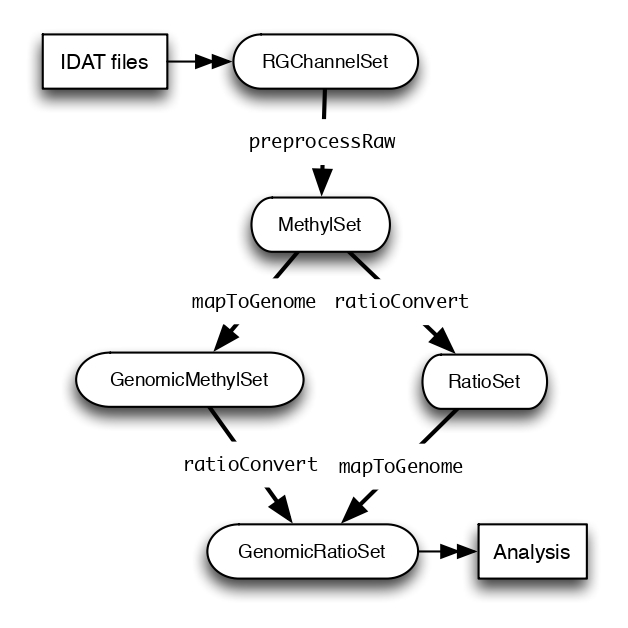
***

***
#### Relembrando
Assim como no EWAStools, a planilha necessita de uma coluna chamada Basename pra achar os arquivos .idat 
***

In [9]:
sheet=read.csv("phenotype_file_GSE191276.csv")
head(sheet)

,GeoID,SampleID,Basename,Sentrix_ID,Sentrix_Position,Age,Sex,case.control,ancestry
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,GSM5742874,202702240141_R05C01,GSM5742874_202702240141_R05C01,202702240141,R05C01,NA,undef,Pooled controls,NA
2,GSM5742875,202702240141_R06C01,GSM5742875_202702240141_R06C01,202702240141,R06C01,17.8,F,Case,Asian
3,GSM5742876,202702240141_R08C01,GSM5742876_202702240141_R08C01,202702240141,R08C01,27.0,M,Case,White
4,GSM5742877,204088150175_R01C01,GSM5742877_204088150175_R01C01,204088150175,R01C01,20.9,M,Case,Asian
5,GSM5742878,204088150175_R02C01,GSM5742878_204088150175_R02C01,204088150175,R02C01,18.5,F,Control,Unknown (Anonymous blood donor)
6,GSM5742879,204088150175_R03C01,GSM5742879_204088150175_R03C01,204088150175,R03C01,21.0,M,Control,Unknown (Anonymous blood donor)


***
### 1. Lendo .idat files - read.metharray.exp()
Para maior precisão, podeos criar um basename com o caminho completo do diretório em que estão localizados os .idat files.

Uma outra alternativa, é alterar temporariamente o *working directory* para o diretório em que os arquivos .idat estão localizados, que é o que faremos aqui.
***

In [13]:
if (file.exists("./minfiRGset.RData")){
    load("./minfiRGset.RData")
} else{
    RGSet <- minfi::read.metharray.exp(targets = sheet, verbose = FALSE)
    save(RGSet, file = "minfiRGset.RData")
}

In [14]:
RGSet

class: RGChannelSet 
dim: 1051815 7 
metadata(0):
assays(2): Green Red
rownames(1051815): 1600101 1600111 ... 99810990 99810992
rowData names(0):
colnames(7): GSM5742874_202702240141_R05C01
  GSM5742875_202702240141_R06C01 ... GSM5742879_204088150175_R03C01
  GSM5742880_204088150175_R04C01
colData names(7): GeoID SampleID ... Sex filenames
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19

***
### 2. Phenotype file
A partir do RGset conseguimos acessar praticamente qualquer informação, inclusive o *phentype file*

In [112]:
head(pData(RGSet)[,1:4])

DataFrame with 6 rows and 4 columns
                                     GeoID            SampleID
                               <character>         <character>
GSM8288007_204963470004_R01C01  GSM8288007 204963470004_R01C01
GSM8288008_204963470004_R02C01  GSM8288008 204963470004_R02C01
GSM8288009_204963470004_R03C01  GSM8288009 204963470004_R03C01
GSM8288010_204963470004_R04C01  GSM8288010 204963470004_R04C01
GSM8288011_204963470004_R05C01  GSM8288011 204963470004_R05C01
GSM8288012_204963470004_R06C01  GSM8288012 204963470004_R06C01
                                             Basename  Sentrix_ID
                                          <character>   <numeric>
GSM8288007_204963470004_R01C01 GSM8288007_204963470.. 2.04963e+11
GSM8288008_204963470004_R02C01 GSM8288008_204963470.. 2.04963e+11
GSM8288009_204963470004_R03C01 GSM8288009_204963470.. 2.04963e+11
GSM8288010_204963470004_R04C01 GSM8288010_204963470.. 2.04963e+11
GSM8288011_204963470004_R05C01 GSM8288011_204963470.. 2.04963e+1

***
## 3. Manifest/Annotation

Para arrays de methylação, temos dois tipos de pacotes de anotação: 
#### "manifest" packages: 
Estes, contém um design de array
#### "Annotation" packages:
Estes contem informação sobre onde os loci de methulação estão localizados no genoma, quais características genômicas eles mapeiam possivelmente a localização em que eles se sobrepõe a SNPs conhecidos


É possivel ver informações sobre quais os pacotes específicos que estão sendo utilizados no seu RGset usando as funções abaixo:

In [113]:
annotation(RGSet)

array                     annotation 
"IlluminaHumanMethylationEPIC"                 "ilm10b4.hg19"

***
Em seguida, vamos carregar o manifest especifico que o nosso RGset está usando: 'IlluminaHumanMethylationEPIC'

In [85]:
library(IlluminaHumanMethylationEPICmanifest)
manifest <- getManifest(RGSet)
manifest

IlluminaMethylationManifest object
Annotation
  array: IlluminaHumanMethylationEPIC
Number of type I probes: 142262 
Number of type II probes: 724574 
Number of control probes: 635 
Number of SNP type I probes: 21 
Number of SNP type II probes: 38 

In [86]:
head(getProbeInfo(manifest))

DataFrame with 6 rows and 8 columns
         Name    AddressA    AddressB       Color       NextBase
  <character> <character> <character> <character> <DNAStringSet>
1  cg18478105    46761277    86644198         Grn              C
2  cg09835024    16745152    81631976         Red              A
3  cg14361672    51800947     7743487         Red              T
4  cg01763666    37768834    23754592         Grn              C
5  cg12950382     8726444    76660327         Red              A
6  cg02115394    68602543    59659581         Red              A
                ProbeSeqA               ProbeSeqB      nCpG
           <DNAStringSet>          <DNAStringSet> <integer>
1 AAATAAATTT...ACAAAAACCA AAATAAATTT...ACGAAAACCG         5
2 AATAAACACC...ACAAAAATCA AATAAACGCC...ACAAAAATCG         5
3 ATCACTACCT...ACATCCTACA ATCACTACCT...ACATCCTACG         2
4 AAACAAAAAT...AAAACAAACA GAACAAAAAT...AAAACAAACG         1
5 ATACCAAAAA...CCAAATAACA GTACCGAAAA...CCGAATAACG         3
6 AAAATCACTA...AAAAAACTC

### 4. Pré-processamento - Obtenção do MethylSet (MSet)

Até o momento, nosso objeto RGset contém informações *raw* sobre os canais verde e vermelho. Para continuar, precisamos transformar essas informações em um objeto MethylSet que contem sinais mMed(*methylated median*) e uMed (*unmethylated median*)

#### preprocessRaw()

O modo mais simples de construit um MSet é através desta função. Nela, um array é construido para corresponder as diferentes probes e os canais de cores para construor os sinais mMed e uMed ***SEM REALIZAR NENHUMA NORMALIZAÇÃO***. Não realizr a normalização neste ponto é importante para a chackagem de qualidade.

In [16]:
MSet <- preprocessRaw(RGSet) 
MSet

class: MethylSet 
dim: 866091 7 
metadata(0):
assays(2): Meth Unmeth
rownames(866091): cg18478105 cg09835024 ... cg10633746 cg12623625
rowData names(0):
colnames(7): GSM5742874_202702240141_R05C01
  GSM5742875_202702240141_R06C01 ... GSM5742879_204088150175_R03C01
  GSM5742880_204088150175_R04C01
colData names(7): GeoID SampleID ... Sex filenames
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19
Preprocessing
  Method: Raw (no normalization or bg correction)
  minfi version: 1.38.0
  Manifest version: 0.3.0

preprocess

***
#### getMeth e getUnmeth

Estas funções podem ser utilizadas para acessarmos as matrizes de *intensidades de metilação/não-metilação* de cada CpG para cada indivíduo 

In [17]:
head(getMeth(MSet)[,1:3])

,GSM5742874_202702240141_R05C01,GSM5742875_202702240141_R06C01,GSM5742876_202702240141_R08C01
cg18478105,484,381,294
cg09835024,731,296,726
cg14361672,16165,18047,11519
cg01763666,7347,7734,6157
cg12950382,5929,7114,2163
cg02115394,2174,2034,1139


In [18]:
head(getUnmeth(MSet)[,1:3])

,GSM5742874_202702240141_R05C01,GSM5742875_202702240141_R06C01,GSM5742876_202702240141_R08C01
cg18478105,10967,11775,11549
cg09835024,16526,17822,10813
cg14361672,3025,3760,1643
cg01763666,1854,1708,702
cg12950382,427,442,316
cg02115394,14926,14707,11703


***
### RatioSet - ratioConvert()

O objeto ***RatioSet*** é uma classe designada para armazenar valores de Beta e/ou M-Values ao invés de ***(un)methylated signals***. Ainda, há como armazenar uma matriz CN, que contém a soma dos valores de metilação/não-metilação.

O mapemento do MSet pro ratioSet é irreversível. Isto signica que não há como obter um Mset a partir de um ratioSet.

In [19]:
ratioSet <- ratioConvert(MSet, what = "both", keepCN = TRUE)
ratioSet

class: RatioSet 
dim: 866091 7 
metadata(0):
assays(3): Beta M CN
rownames(866091): cg18478105 cg09835024 ... cg10633746 cg12623625
rowData names(0):
colnames(7): GSM5742874_202702240141_R05C01
  GSM5742875_202702240141_R06C01 ... GSM5742879_204088150175_R03C01
  GSM5742880_204088150175_R04C01
colData names(7): GeoID SampleID ... Sex filenames
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19
Preprocessing
  Method: Raw (no normalization or bg correction)
  minfi version: 1.38.0
  Manifest version: 0.3.0

***
### MapToGenome()

A função **MapToGenome()** aplicada a um objeto ratioSet irá adicionar **coordenadas genômicas** para cada probe juntamente com algumas informações adicionais de anotação. Como output, esta função retorna um objeto do tipo **GenomicRatioSet**


In [20]:
library(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)
GMRset <- mapToGenome(ratioSet)
GMRset

class: GenomicRatioSet 
dim: 865859 7 
metadata(0):
assays(3): Beta M CN
rownames(865859): cg14817997 cg26928153 ... cg07587934 cg16855331
rowData names(0):
colnames(7): GSM5742874_202702240141_R05C01
  GSM5742875_202702240141_R06C01 ... GSM5742879_204088150175_R03C01
  GSM5742880_204088150175_R04C01
colData names(7): GeoID SampleID ... Sex filenames
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19
Preprocessing
  Method: Raw (no normalization or bg correction)
  minfi version: 1.38.0
  Manifest version: 0.3.0

In [22]:
beta <- getBeta(ratioSet)
head(beta)[1:3,1:3]

,GSM5742874_202702240141_R05C01,GSM5742875_202702240141_R06C01,GSM5742876_202702240141_R08C01
cg18478105,0.04226705,0.03134255,0.02482479
cg09835024,0.04235962,0.01633734,0.06291706
cg14361672,0.84236582,0.82757830,0.87517095


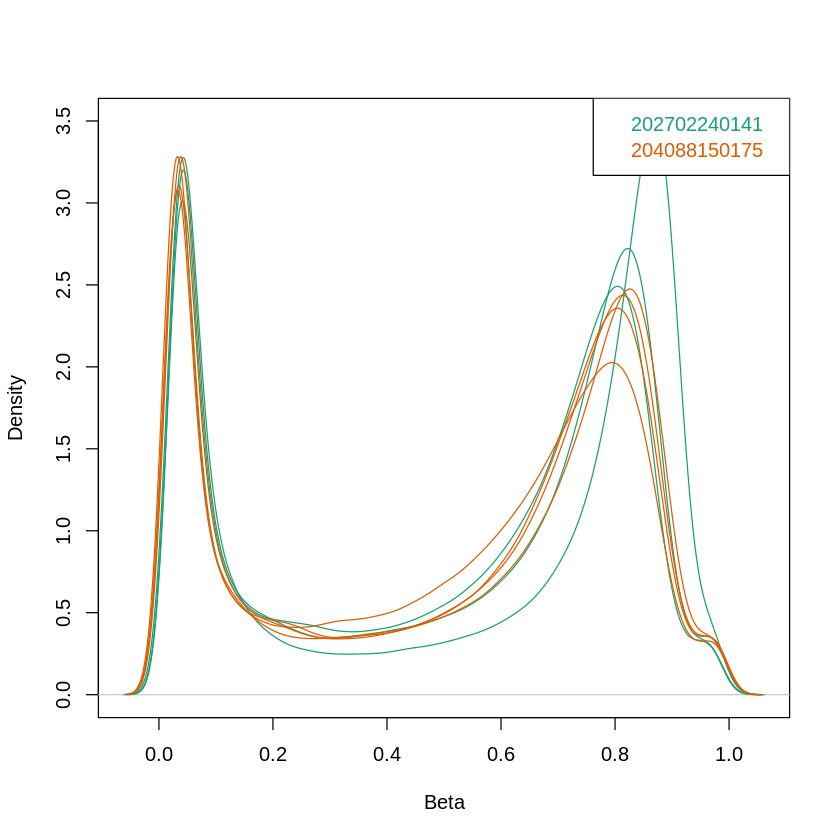

In [27]:
densityPlot(beta, sampGroups = sheet$Sentrix_ID)

***
### 5. Discordância de sexos - getSex()

Função do minfi para verificação dos sexos biológicos relatados. Como input, essa função necessita de um objeto GMRset.


In [28]:
predSex <-  getSex(GMRset)
head(predSex)
sheet$predictedSex <- predSex$predictedSex

sheet$Sex <-  toupper(sheet$Sex)

if(!all(sheet$Sex == sheet$predictedSex)){
    print("Há discordância de sexos na amostra")
    mismatch <- sheet[which(sheet$Sex != sheet$predictedSex),]
    print(mismatch)
} else{
    print("Não há discordância de sexos na amostra")
}



DataFrame with 6 rows and 3 columns
                                    xMed      yMed predictedSex
                               <numeric> <numeric>  <character>
GSM5742874_202702240141_R05C01   13.5306  12.75259            M
GSM5742875_202702240141_R06C01   13.8054   9.47168            F
GSM5742876_202702240141_R08C01   12.7141  13.06508            M
GSM5742877_204088150175_R01C01   12.3476  12.76466            M
GSM5742878_204088150175_R02C01   13.3737   8.38370            F
GSM5742879_204088150175_R03C01   12.9157  13.21037            M

[1] "Há discordância de sexos na amostra"
       GeoID            SampleID                       Basename   Sentrix_ID
1 GSM5742874 202702240141_R05C01 GSM5742874_202702240141_R05C01 202702240141
  Sentrix_Position Age   Sex    case.control ancestry predictedSex
1           R05C01  NA UNDEF Pooled controls     <NA>            M


***
#### Criando uma discordância como exemplo
***

In [104]:
# 1. Crio uma cópia de sheet em sheet2
sheet2 <- copy(sheet)

# 2. Criando alteração de fenótipo na linha 3
sheet2[3,"Sex"] <-  "F"

# 3. Rodando a função getSex() e veridicando o resultado.
predSex <-  getSex(GMRset)
sheet$predictedSex <- predSex$predictedSex

sheet2$Sex <-  toupper(sheet2$Sex)
head(sheet2)
if(!all(sheet2$Sex == sheet2$predictedSex)){
    print("Há discordância de sexos na amostra")
    mismatch <- sheet[which(sheet2$Sex != sheet2$predictedSex),]
} else{
    print("Não há discordância de sexos na amostra")
}

print(mismatch)

,GeoID,SampleID,Basename,Sentrix_ID,Sentrix_Position,Sex,predictedSex
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,GSM8288007,204963470004_R01C01,GSM8288007_204963470004_R01C01,204963470004,R01C01,M,M
2,GSM8288008,204963470004_R02C01,GSM8288008_204963470004_R02C01,204963470004,R02C01,M,M
3,GSM8288009,204963470004_R03C01,GSM8288009_204963470004_R03C01,204963470004,R03C01,F,M
4,GSM8288010,204963470004_R04C01,GSM8288010_204963470004_R04C01,204963470004,R04C01,M,M
5,GSM8288011,204963470004_R05C01,GSM8288011_204963470004_R05C01,204963470004,R05C01,M,M
6,GSM8288012,204963470004_R06C01,GSM8288012_204963470004_R06C01,204963470004,R06C01,M,M


[1] "Há discordância de sexos na amostra"
       GeoID            SampleID                       Basename   Sentrix_ID
3 GSM8288009 204963470004_R03C01 GSM8288009_204963470004_R03C01 204963470004
  Sentrix_Position Sex predictedSex
3           R03C01   m            M


***
### 6. getBeta, getM e getCN

Estas funções recebem como input o *GenomicRatioSet* e retornam, respectivamente, o Beta, a matrix de M values e a matriz de *Copy Number*

Muito mais dados de anotaçãopodem ser extraidos deste objeto (GMRSet). Agora, temos um objeto pronto pra análise, ***porém***, não normalizado. 

In [107]:
beta <- getBeta(GMRset)
head(beta)

Mval <- getM(GMRset)
head(Mval)

cn <- getCN(GMRset)
head(cn)

save(beta,file="output/raw_betaGMRset.RData")

,GSM8288007_204963470004_R01C01,GSM8288008_204963470004_R02C01,GSM8288009_204963470004_R03C01,GSM8288010_204963470004_R04C01,GSM8288011_204963470004_R05C01,GSM8288012_204963470004_R06C01,GSM8288013_204963470004_R07C01,GSM8288014_204963470004_R08C01,GSM8288015_204963470068_R01C01,GSM8288016_204963470068_R02C01,GSM8288017_204963470068_R03C01,GSM8288018_204963470068_R04C01,GSM8288019_204963470068_R05C01,GSM8288020_204963470068_R06C01,GSM8288021_204963470068_R07C01,GSM8288022_204963470068_R08C01,GSM8288023_204963470085_R01C01,GSM8288024_204963470085_R02C01,GSM8288025_204963470085_R03C01,GSM8288026_204963470085_R04C01
cg14817997,0.7171825,0.7616646,0.7086093,0.7487083,0.7813765,0.6197749,0.75604919,0.7319885,0.7198892,0.7054264,0.7420719,0.7821782,0.7246812,0.7183811,0.6494024,0.60654685,0.5876701,0.5062035,0.6399287,0.6813597
cg26928153,0.9187742,0.9081897,0.8980069,0.9291535,0.9181916,0.8864167,0.91232356,0.9305536,0.9149766,0.9300035,0.9154930,0.9178628,0.8959649,0.9002865,0.8942127,0.91481810,0.8765866,0.8841065,0.8839220,0.9053485
cg16269199,0.7603754,0.7441860,0.7317378,0.7668849,0.7485030,0.7632562,0.77441136,0.8104496,0.7839774,0.7607163,0.7815543,0.7827586,0.7310423,0.7178861,0.7375019,0.73236010,0.6799594,0.7076196,0.6920877,0.7443307
cg13869341,0.8159417,0.8204421,0.8218100,0.8296918,0.8344162,0.8175653,0.84525305,0.8490093,0.8097466,0.8210457,0.8416549,0.8342904,0.8887395,0.8642143,0.8707340,0.88813295,0.8522592,0.8697328,0.8693684,0.8637469
cg14008030,0.5266966,0.5419778,0.5580852,0.5542199,0.5513112,0.5963693,0.58328988,0.5300849,0.5055300,0.5326393,0.5227342,0.5590750,0.6180986,0.6512133,0.6435746,0.63244057,0.5096507,0.5062919,0.5287245,0.5180087
cg12045430,0.1160644,0.1194303,0.1346676,0.1217372,0.1158107,0.0962223,0.08949843,0.0973824,0.1321712,0.1380200,0.1272841,0.1457796,0.1210815,0.1224271,0.1082769,0.09654252,0.1412242,0.1397754,0.1348331,0.1260030


,GSM8288007_204963470004_R01C01,GSM8288008_204963470004_R02C01,GSM8288009_204963470004_R03C01,GSM8288010_204963470004_R04C01,GSM8288011_204963470004_R05C01,GSM8288012_204963470004_R06C01,GSM8288013_204963470004_R07C01,GSM8288014_204963470004_R08C01,GSM8288015_204963470068_R01C01,GSM8288016_204963470068_R02C01,GSM8288017_204963470068_R03C01,GSM8288018_204963470068_R04C01,GSM8288019_204963470068_R05C01,GSM8288020_204963470068_R06C01,GSM8288021_204963470068_R07C01,GSM8288022_204963470068_R08C01,GSM8288023_204963470085_R01C01,GSM8288024_204963470085_R02C01,GSM8288025_204963470085_R03C01,GSM8288026_204963470085_R04C01
cg14817997,1.3424689,1.6761623,1.2820354,1.575041,1.8375695,0.7048907,1.6318898,1.4495259,1.36177761,1.2598671,1.5245899,1.8443491,1.3962431,1.3510053,0.8892965,0.6244273,0.51120763,0.03580072,0.8296286,1.0964881
cg26928153,3.4997010,3.3062661,3.1382542,3.713149,3.4884744,2.9642340,3.3792845,3.7441174,3.42780297,3.7318805,3.4374053,3.4821716,3.1063724,3.1745240,3.0794520,3.4248661,2.82839763,2.93142035,2.9288249,3.2577762
cg16269199,1.6659358,1.5405684,1.4476831,1.717968,1.5734669,1.6888405,1.7794057,2.0961407,1.85962964,1.6686366,1.8390716,1.8492686,1.4425757,1.3474769,1.4903397,1.4522600,1.08719341,1.27512748,1.1684354,1.5416644
cg13869341,2.1483030,2.1919524,2.2053881,2.284427,2.3332060,2.1639536,2.4494723,2.4913209,2.08954803,2.1978715,2.4101564,2.3318922,2.9978198,2.6700577,2.7518887,2.9889905,2.52822357,2.73909806,2.7344643,2.6643190
cg14008030,0.1542067,0.2428162,0.3367168,0.314126,0.2971519,0.5631699,0.4851689,0.1738232,0.03191378,0.1886223,0.1312849,0.3425085,0.6946369,0.9007849,0.8525074,0.7829524,0.05569901,0.03631136,0.1659455,0.1039691
cg12045430,-2.9290155,-2.8822686,-2.6838518,-2.850882,-2.9325871,-3.2315248,-3.3467272,-3.2123820,-2.71500241,-2.6427768,-2.7774603,-2.5508195,-2.8597514,-2.8415962,-3.0418701,-3.2262204,-2.60429434,-2.62160308,-2.6818034,-2.7941702


,GSM8288007_204963470004_R01C01,GSM8288008_204963470004_R02C01,GSM8288009_204963470004_R03C01,GSM8288010_204963470004_R04C01,GSM8288011_204963470004_R05C01,GSM8288012_204963470004_R06C01,GSM8288013_204963470004_R07C01,GSM8288014_204963470004_R08C01,GSM8288015_204963470068_R01C01,GSM8288016_204963470068_R02C01,GSM8288017_204963470068_R03C01,GSM8288018_204963470068_R04C01,GSM8288019_204963470068_R05C01,GSM8288020_204963470068_R06C01,GSM8288021_204963470068_R07C01,GSM8288022_204963470068_R08C01,GSM8288023_204963470085_R01C01,GSM8288024_204963470085_R02C01,GSM8288025_204963470085_R03C01,GSM8288026_204963470085_R04C01
cg14817997,10.87191,11.21614,10.56033,11.05596,11.27030,10.28077,11.29978,11.02375,11.08148,10.91812,11.20762,11.65821,11.38046,10.79685,10.77890,10.60548,10.28656,10.65464,11.45379,11.38640
cg26928153,12.40328,12.67882,12.64881,12.89330,12.85953,12.64993,12.84706,12.79340,12.64611,12.49835,12.70434,12.87728,12.92128,12.76901,12.75843,12.72323,12.32221,12.61494,12.73619,12.64678
cg16269199,12.22732,12.41495,12.45095,12.50283,12.47117,12.38694,12.49586,12.49210,12.37314,12.35783,12.35452,12.70347,12.78177,12.67662,12.69283,12.49035,11.94288,12.31033,12.35673,12.41680
cg13869341,14.32860,14.54659,14.54345,14.55519,14.61465,14.52601,14.72441,14.86926,14.72856,14.74326,14.71414,14.84505,14.70908,14.61022,14.72307,14.71521,14.51792,14.74741,14.56897,14.54231
cg14008030,13.75468,13.91074,13.82764,13.97817,14.02773,14.08738,14.07506,14.18410,13.97424,13.79523,13.99232,14.08904,14.01968,13.89245,13.91354,13.96064,13.87008,13.80413,13.91924,13.95756
cg12045430,13.89898,14.13923,14.19745,14.15450,14.12557,14.08829,14.22430,14.35101,14.37741,14.45603,14.34783,14.45674,14.44255,14.25702,14.35631,14.40680,14.21250,14.38330,14.30385,14.23758


*** 
### 7. Controle de qualidade de MethylSet - 
#### 7.1 getQC()

Com a função **getQC()**, minfi provê um controle de qualidade simples que utiliza a ***mediana de intensidade*** de ambos os canais **Metilado** e **Não-metilado**. Quando plotados, as boas amostras tendem a permanecer juntas (também chamadas de*cluster*), enquanto que más amostras tendem a ficar separadas e apresentam ***menores medianas de intensidade***

Em geral, o analista deve fazer um julgamento com base na linha de ponto de corte que é inserida no gráfico pela função **plotQC()**.

Ambas as funções obtém as informações de entrada (*input*) do objeto **MethylSet**.

In [21]:
MSet

class: MethylSet 
dim: 866238 20 
metadata(0):
assays(2): Meth Unmeth
rownames(866238): cg18478105 cg09835024 ... cg10633746 cg12623625
rowData names(0):
colnames(20): GSM8288007_204963470004_R01C01
  GSM8288008_204963470004_R02C01 ... GSM8288025_204963470085_R03C01
  GSM8288026_204963470085_R04C01
colData names(7): GeoID SampleID ... Sex filenames
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19
Preprocessing
  Method: Raw (no normalization or bg correction)
  minfi version: 1.38.0
  Manifest version: 0.3.0

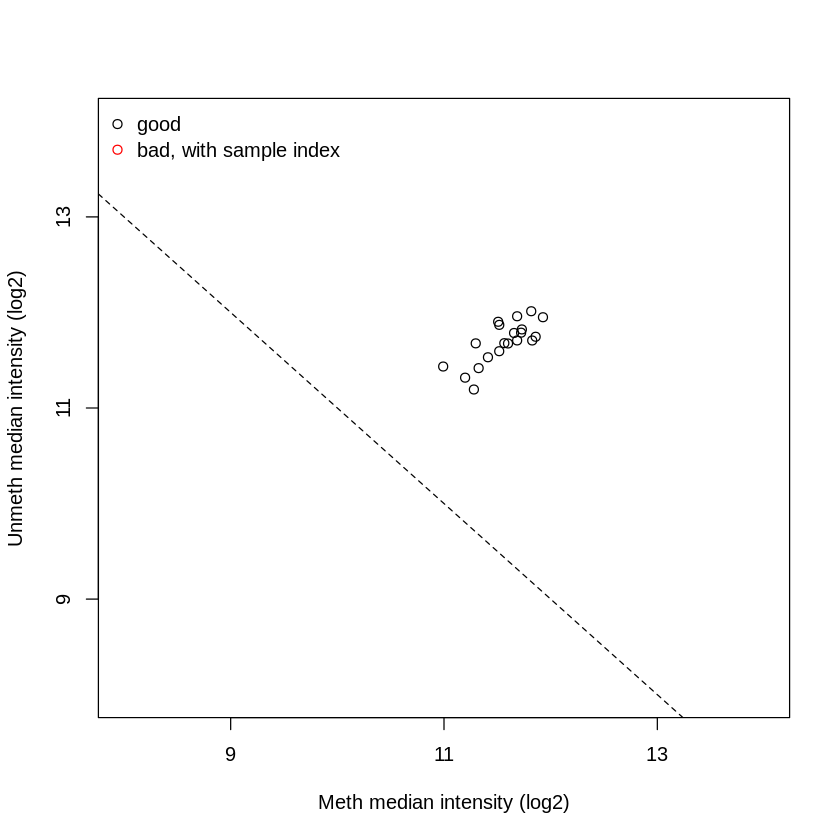

In [28]:
qc <- getQC(MSet)
QCmetrics <- cbind(sheet,qc)

plotQC(qc)

***
Se houverem amostras caracterizadas como *bad samples*, como descobrir seus id's?

Normalmente, o controle de qualidade não se baseia apenas em uma metodologia. a função getQC compara o sinal total (U+M) para cada probre comparada ao sinal de fundo (*background signal*). Este, é estimado a partir de **probes de controle negativo**.

valores de P muito pequenos são indicativo de sinais confiávies, enquanto que valores de p > 0.01, por exemplo, geralmente indicam sinais de baixa qualidade 
***
Observação:

O valor de corte para P-val padrão é 0.01. Entretanto, esse pode e deve ser alterado de acordo com o contexto do analista.
***

#### 7.2 detectionP()

A partir dessa função iremos obter a media de valores de P para cada amostra. Nos permitindo inferir a confiabilidade de cada dado. 

**Amostras com muitas probes falhas tendem a ter maior valor de p**



In [29]:
detP <- detectionP(RGSet)
detP[1:5,1:5]

,GSM5742874_202702240141_R05C01,GSM5742875_202702240141_R06C01,GSM5742876_202702240141_R08C01,GSM5742877_204088150175_R01C01,GSM5742878_204088150175_R02C01
cg18478105,0.000000e+00,0,0.000000e+00,0.000000e+00,0
cg09835024,0.000000e+00,0,0.000000e+00,0.000000e+00,0
cg14361672,0.000000e+00,0,0.000000e+00,0.000000e+00,0
cg01763666,0.000000e+00,0,0.000000e+00,0.000000e+00,0
cg12950382,1.051572e-282,0,1.290293e-40,2.682159e-53,0


Em seguida, iremos plotar a média de valores de P para cada amostra em um gráfico de barras para observar melhor os dados.

Dados de **baixa confiabilidade*** serão destacados como vermelho

h (altura da coluna) < 0.05, neste código exemplo*

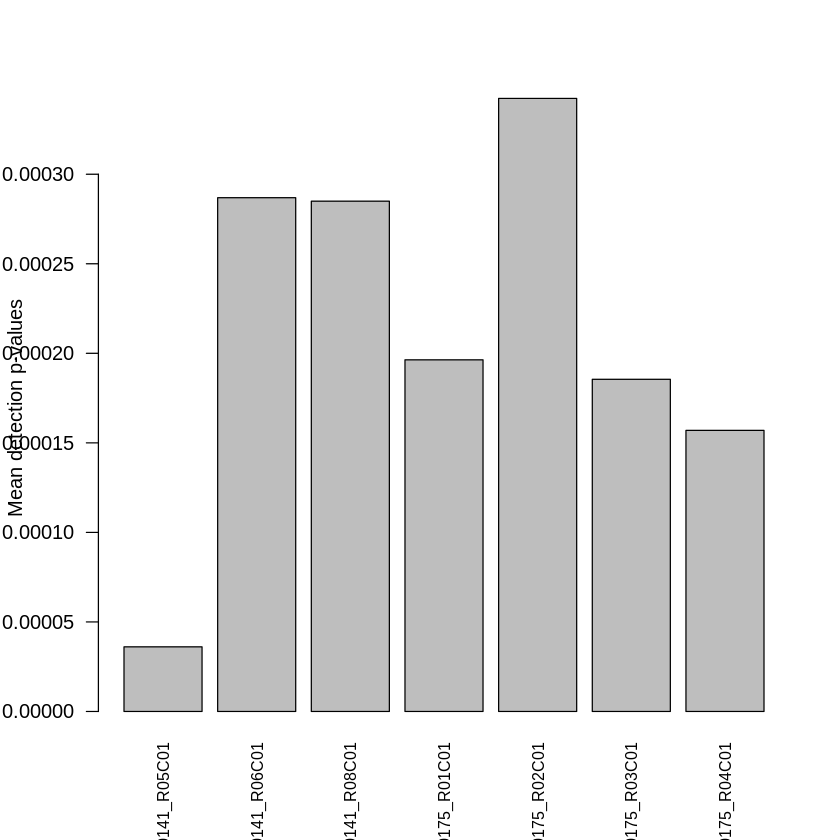

In [30]:
barplot(colMeans(detP), las=2, cex.names=0.8, ylab="Mean detection p-values")
abline(h=0.05,col="red")

#### 7.3 Density plot

Outra maneira de avaliar a qualidade dos dados é observar a distribuição geral de valores de Beta em cada amostra (indivíduo). Em geral, se espera observar valores de beta **proximos a 0** ou **próximos a 1**, que indicariam que o sítio CpG está não-metilado ou metilado respectivamente.

a função **densityPlot** plota a distribuição de cada indivíduo

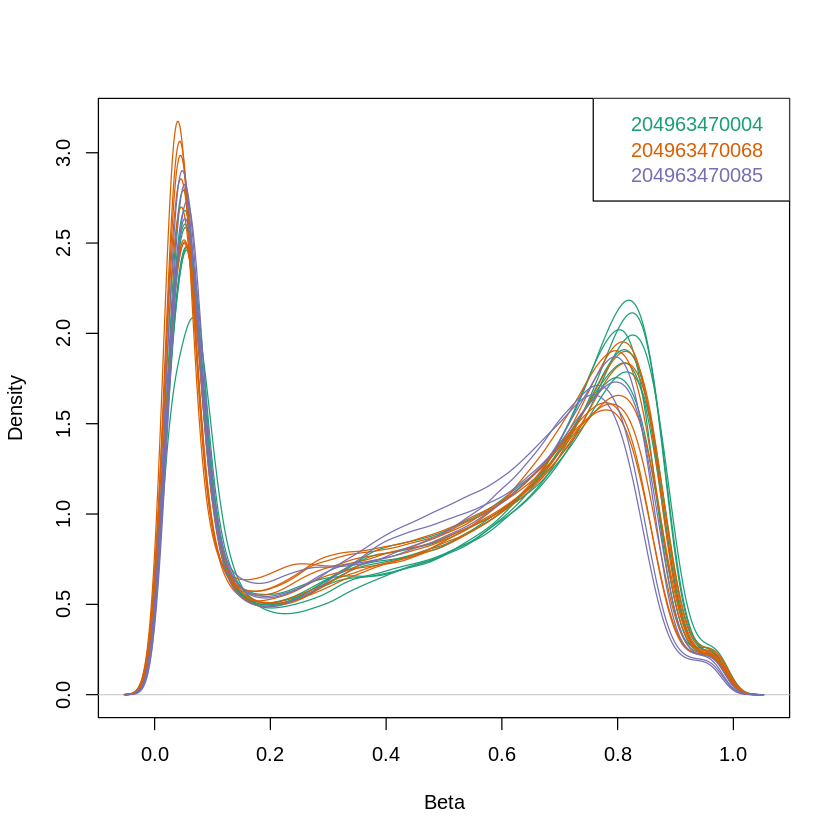

In [27]:
phenoData <- pData(MSet)
densityPlot(MSet, sampGroups = sheet$Sentrix_ID)

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


ERROR: Error in pdf(file = pdf, width = 8, height = 11): cannot open file 'output/qcReport.pdf'


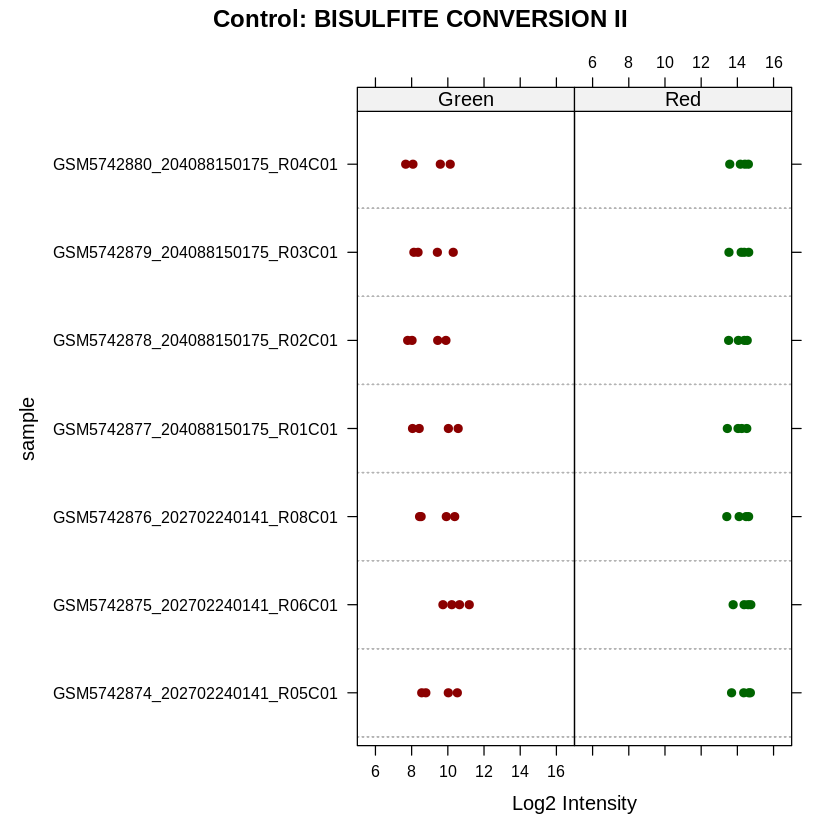

In [31]:
controlStripPlot(RGSet, controls="BISULFITE CONVERSION II")
# The plots of the different control probes can be exported into a pdf file in one step using the function qcReport
qcReport(RGSet, pdf= "output/qcReport.pdf")

In [ ]:
# 1. Em uma lista, selecione as amostras que você quer que FIQUEM. Neste exeplo, manteremos todos os individuos COM EXCEÇÃO DO GSM8288008_204963470004_R02C01
keep <- !colnames(RGSet) == "GSM8288008_204963470004_R02C01"
# 2. Criação de um subset do RGset das amostras sem o indivíduo selecionado. 
RGSet2 <- RGSet[,keep]
# 3. Verifque se retirou as colunas desejadas corretamente
print(RGSet2)
# 4. Crie um subset da planilha de fenótipos também.
sheet2 <- sheet[keep,]

In [35]:
qc <- getQC(MSet)
QCmetrics <- cbind(sheet, qc)

 [1] GeoID            SampleID         Basename         Sentrix_ID      
 [5] Sentrix_Position Age              Sex              case.control    
 [9] ancestry         predictedSex     mMed             uMed            
<0 rows> (or 0-length row.names)


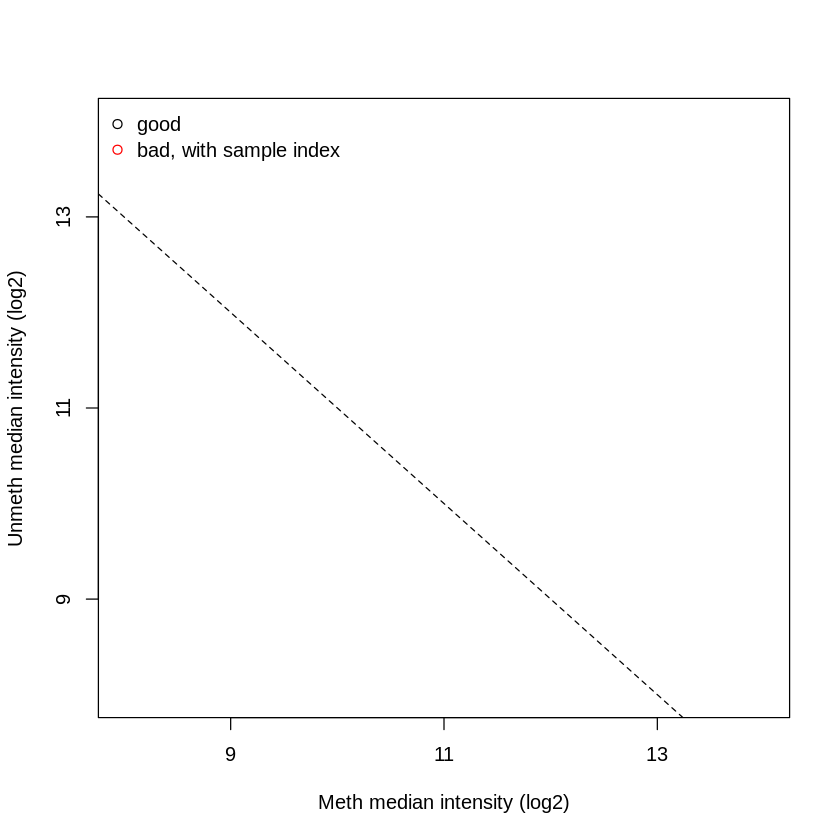

In [36]:
minfi_failed <- QCmetrics[ which(( (QCmetrics$mMed + QCmetrics$uMed)/2 < 10.5)), ]
print(minfi_failed)
QCmetrics$minfi_failed <- ifelse((QCmetrics$mMed + QCmetrics$uMed)/2 < 10.5, TRUE, FALSE)
plotQC(minfi_failed)

***
## 8. Normalização 

O minfi possui diversos tipos de normalização disponíveis. Cabe ao analista decidir qual é a mais adequada para o modelo em estudo. Neste exemplo, iremos realizar a **Quantile normalization**. Porém, as demais funções seguem o mesmo formado **preproecess*Método()***

### preprocessQuantile
>**input**: RGChannelSet

>**output**: GenomicRatioSet

Essa função implementa uma normalização quantil estratificada. O procedimento da normalização é aplicado as intensidades methiladas e não-metiladas **separadamente**. O procedimento de normalização é aplicado às intensidades de metilação e e não-metilação separadamente. A distribuição dos sinais do tipo I e do tipo II é forçada a ser a mesma, primeiro normalizando o quantil das probes do tipo II entre as amostras e depois interpolando uma distribuição de referência para a qual normalizamos as probes do tipo I. Como os tipos de probes e as regiões das probes são confundidos e sabemos que a metilação do DNA varia entre as regiões, estratificamos as sondas por região antes de aplicar esta interpolação. Observe que este algoritmo se baseia nas suposições necessárias para que a normalização por quantil seja aplicável e, portanto, não é recomendado para casos em que são esperadas mudanças globais, como em comparações entre câncer e normal, pois estas seriam removidas pela normalização.

In [20]:
GMRset_norm <- preprocessQuantile(RGSet)
GMRset_norm
beta_norm <- getBeta(GMRset_norm)


#Como comparativos, vamos calcular os demais
beta_funnorm <- preprocessFunnorm(RGSet) %>% getBeta
beta_SWAN <- preprocessSWAN(RGSet) %>% getBeta

[preprocessQuantile] Mapping to genome.

[preprocessQuantile] Fixing outliers.

[preprocessQuantile] Quantile normalizing.



class: GenomicRatioSet 
dim: 865859 20 
metadata(0):
assays(2): M CN
rownames(865859): cg14817997 cg26928153 ... cg07587934 cg16855331
rowData names(0):
colnames(20): GSM8288007_204963470004_R01C01
  GSM8288008_204963470004_R02C01 ... GSM8288025_204963470085_R03C01
  GSM8288026_204963470085_R04C01
colData names(10): GeoID SampleID ... yMed predictedSex
Annotation
  array: IlluminaHumanMethylationEPIC
  annotation: ilm10b4.hg19
Preprocessing
  Method: Raw (no normalization or bg correction)
  minfi version: 1.40.0
  Manifest version: 0.3.0

[preprocessFunnorm] Background and dye bias correction with noob

[preprocessFunnorm] Mapping to genome

[preprocessFunnorm] Quantile extraction

[preprocessFunnorm] Normalization



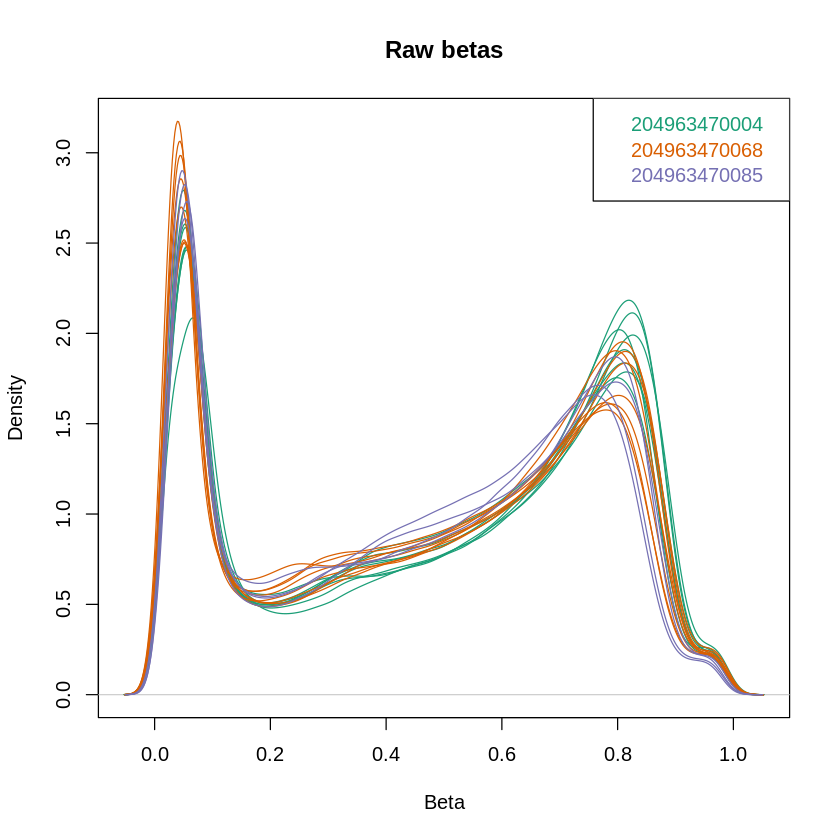

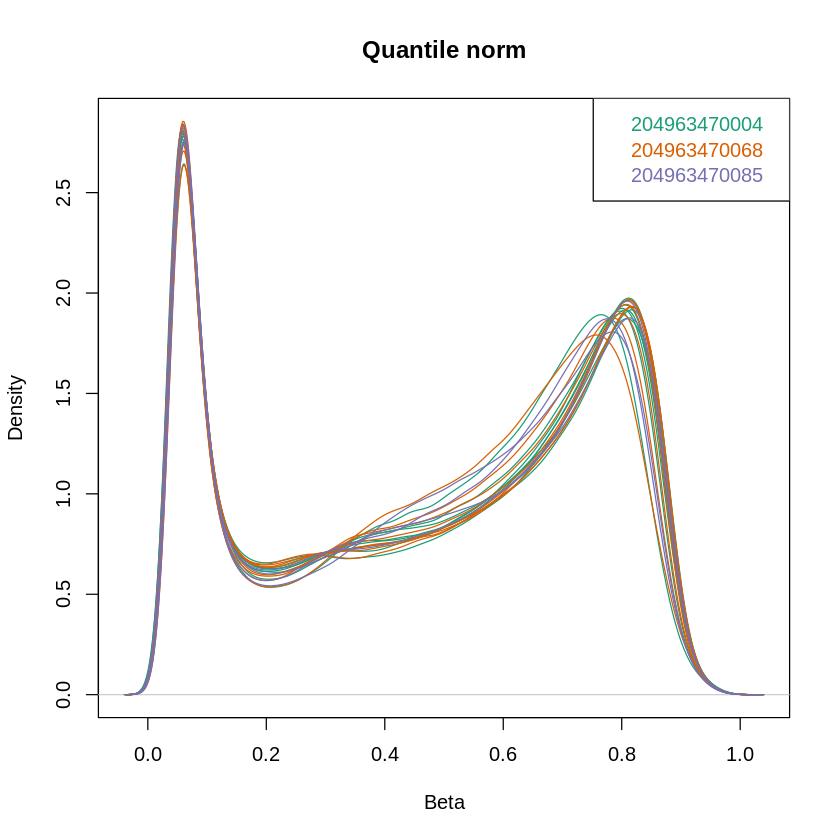

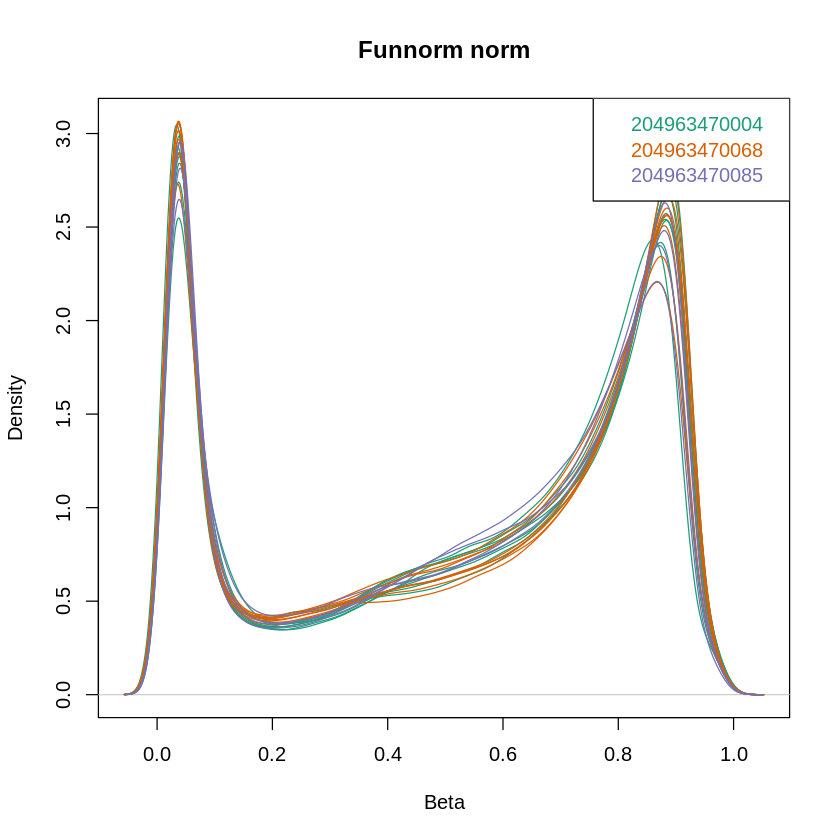

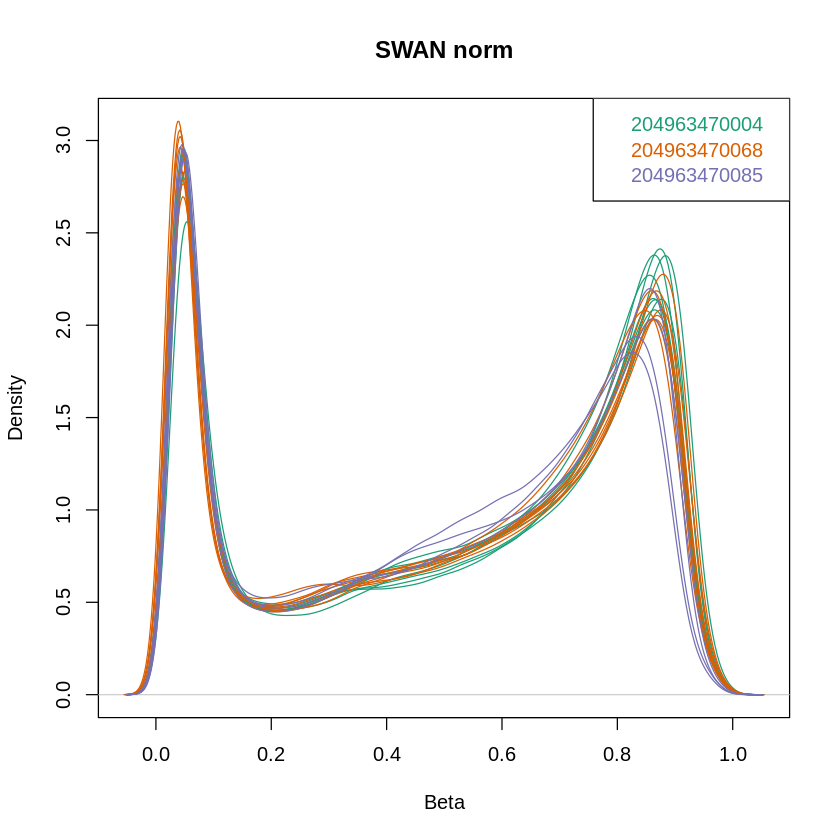

In [22]:
#Iremos comparar agora se houve diferenca na distribuição de betas, tornando-os mais comparáveis ou não.
densityPlot(MSet, sampGroups = sheet$Sentrix_ID, main ="Raw betas")
densityPlot(beta_norm, sampGroups = sheet$Sentrix_ID, main = "Quantile norm")
densityPlot(beta_funnorm, sampGroups = sheet$Sentrix_ID, main = "Funnorm norm")
densityPlot(beta_SWAN, sampGroups = sheet$Sentrix_ID, main = "SWAN norm")

In [ ]:
densityBeanPlot(MSet, sampGroups = sheet$Sentrix_ID)

In [ ]:
controlStripPlot(RGSet, controls="BISULFITE CONVERSION II")

In [ ]:
MSet.illumina <- preprocessIllumina(RGSet, bg.correct = TRUE,
                               normalize = "controls")

In [ ]:
MSet.swan <- preprocessSWAN(RGSet)

In [ ]:
GRset.quantile <- preprocessQuantile(RGSet, fixOutliers = TRUE,
  removeBadSamples = FALSE, badSampleCutoff = 10.5,
  quantileNormalize = TRUE, stratified = TRUE, 
  mergeManifest = FALSE, sex = NULL)

Tem uma opção pra remover samples ruins, eu tive que tirar isso.

In [ ]:
snps <- getSnpInfo(GRset)
head(snps,10)

In [ ]:
GRset <- addSnpInfo(GRset)

In [ ]:
GRset <- dropLociWithSnps(GRset, snps=c("SBE","CpG"), maf=0)

In [ ]:
beta <- getBeta(GRset.funnorm)
dmp <- dmpFinder(beta, pheno = sheet$Sex  , type = "continuous")
head(dmp)

###### Batch effects

In [ ]:
library(sva)
mval <- getM(GRset)[1:5000,]
pheno <- pData(GRset)
mod <- model.matrix(~as.factor(Sex), data=sheet)
mod0 <- model.matrix(~1, data=sheet)
sva.results <- sva(mval, mod, mod0)

In [ ]:
ab <- compartments(grset.quantile, chr="chr14", resolution=100`1000)